In [1]:
import os
os.chdir(r'4 - Transformer')
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import chain
from itertools import groupby
from functools import reduce
from typing import Collection, List
from pathlib import Path
import music21 as m21
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)
from midi_encoding import *

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [2]:
if device == "cuda":
    print(f"Device: {torch.cuda.get_device_name()}.")

Device: NVIDIA GeForce RTX 4090.


In [3]:
vocab = MusicVocab()
vocab.size

Vocab length: 389
Padding vocab 5
Padded vocab length: 392


392

In [4]:
vg_large_path = Path('../data/midi/vg_large')
vg_large_file_names = [f for f in os.listdir(vg_large_path) if os.path.isfile(os.path.join(vg_large_path, f))]
len(vg_large_file_names)

3839

### Data loading

Previously we used a fixed context window to split out data into blocks, e.g. 'if we see this block of 8 tokens, what is the ninth?'.

That meant we always had to init the generation with an entire block of context, mostly made of padding. We also needed to add these 'padding init' blocks to training so that the network had seen them before inference time.

Now that we are working with transformers, we will take each block and split it into samples of varying lengths, e.g.

Data - (1, 2, 3, 4)

X(1) -> Y(2)

X(1,2) -> Y(3)

X(1,2,3) -> Y(4)

Because we are going to drastically scale up our block size, it is no longer feasible to pre-block encode the data as every token is duplicated up to block size.

We will need to load a single 1D tensor, then randomly indexes into it to choose a block.

This does mean that at boundaries we will have blocks of performances overlapping (i.e. there will be blocks with a token *after* `<|eos|>`), but hopefully the network will realise that data before and after is correlated.

Alternatively, we could try re-sampling if we get a block with `<|eos|>` anywhere other than the end?

In this notebook we are going to encode the entire dataset at once and *then* split into train / test / validation data, rather than first split by filenames, because it occured to me that the MIDI tracks might have very different lengths.


### Labels

Because we are training every position in the sequence at once, we need a block of labels for each block of data.

This is just the next block in the array (i.e. `X[1]` is the labels for `X[0]`, and `X[2]` is the labels for `X[1]` etc etc), so there is no point in encoding them separately.

### Position

We are going to need to add positional encodings to our data.

Transformers employ a position embedding layer to distinguish between positions in a sequence.

In addition to this, we want to create embeddings for the bar and beat.

These can all be added together to get a hybrid 'position' vector.

To allow us to calculate the bar and beat we need the absolute position of each token, which we can encode at the same time as the batches.

> See `sparse_to_position_enc` - this is where we throw away timestep info, so we now 'snaphot' tidx and package alongside the token values.

In [5]:
def idx_encode(file_names):
    # We can't shuffle the blocks afterwards as we rely on them being contiguous in order to get the targets
    # If we didn't shuffle at all then the train and test splits would contain specific game soundtracks rather than a mixture
    random.shuffle(file_names)
    xs = []
    for file_name in file_names:
        file_path = Path(vg_large_path, file_name)
        idx_score = midifile_to_idx_score(file_path, vocab, False)
        if idx_score is not None: # Files which aren't 4/4 are ignored
            xs.append(idx_score)
    return np.concat(xs) # concat scores to create 1D tensor

def load_or_create(file_names, sample_path):
    if sample_path.exists():
        xs = np.load(sample_path, allow_pickle=True)
    else:
        xs = idx_encode(file_names)
        np.save(sample_path, xs)

    return torch.tensor(xs, device=device)

vg_large_samples_path = Path(f'../data/numpy/vg_large/samples_with_position_all.npy')

data = load_or_create(vg_large_file_names, vg_large_samples_path)

data.shape

torch.Size([8781624, 2])

In [6]:
X = data[0:-1]
Y = data[1:, 0] # Drop position from Y
# Y = data[1:]

In [7]:
X[:12]

tensor([[  0,   0],
        [ 46,   0],
        [138,   0],
        [  3,   0],
        [138,   0],
        [ 45,   6],
        [134,   6],
        [  3,   6],
        [134,   6],
        [ 44,   8],
        [138,   8],
        [  3,   8]], device='cuda:0')

In [8]:
X[-12:]

tensor([[  69, 1356],
        [ 136, 1356],
        [   3, 1356],
        [ 136, 1356],
        [  80, 1360],
        [ 135, 1360],
        [  68, 1360],
        [ 135, 1360],
        [  61, 1360],
        [ 135, 1360],
        [  49, 1360],
        [ 135, 1360]], device='cuda:0')

In [9]:
vocab.to_tokens(X[:, 0][:12])
# vocab.to_tokens(X[:][:12])

'<|sos|> n42 d6 <|sep|> d6 n41 d2 <|sep|> d2 n40 d6 <|sep|>'

In [10]:
vocab.to_tokens(Y[:12])

'n42 d6 <|sep|> d6 n41 d2 <|sep|> d2 n40 d6 <|sep|> d6'

In [11]:
vocab.to_tokens(X[:, 0][-12:])
# vocab.to_tokens(X[:][-12:])

'n65 d4 <|sep|> d4 n76 d3 n64 d3 n57 d3 n45 d3'

In [12]:
vocab.to_tokens(Y[-12:])

'd4 <|sep|> d4 n76 d3 n64 d3 n57 d3 n45 d3 <|eos|>'

We are now ready to build a decoder-only transformer with positional embeddings.

We will start by creating simple custom PyTorch modules following Karpathy in order to fully understand the architecture.

In [13]:
n_embed = 384 # /6 heads = 64 per head
block_size = 256
dropout = 0.2

class SelfAttentionHead(torch.nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = torch.nn.Linear(n_embed, head_size, bias=False)
        self.query = torch.nn.Linear(n_embed, head_size, bias=False)
        self.value = torch.nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        
        # Key - What it offers
        k = self.key(x) # (B, T, C)

        # Query - What it looks for
        q = self.query(x) # (B, T, C)

        # Attention scores
        w = q @ k.transpose(-2, -1) * C ** -0.5 # i.e. math.sqrt(self.embed_size). (B, T, C) @ (B, C, T) -> (B, T, T)

        w = w.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T) Mask the future positions 
        w = F.softmax(w, dim=-1) # (B, T, T)
        w = self.dropout(w)

        # Value - What it has to communicate
        v = self.value(x) # (B, T, C)
        
        # Scale the values by the attention weights
        return w @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
    
class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_heads, head_size):
        super().__init__()
        self.heads = torch.nn.ModuleList([SelfAttentionHead(head_size) for _ in range(n_heads)])
        self.proj = torch.nn.Linear(n_heads * head_size, n_embed) 
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        # Concat over the channel dimension
        out = torch.cat([h(x) for h in self.heads], dim=-1) # Could all be done in parallel by adding a head dimension
        out = self.proj(out)
        return self.dropout(out)
    
class FeedForward(torch.nn.Module):

    def __init__(self, n_embed):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_embed, 4 * n_embed), # 4x is a common expansion factor
            torch.nn.ReLU(),
            torch.nn.Linear(4 * n_embed, n_embed), # Project back to the residual stream
            torch.nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)
    
class Block(torch.nn.Module):

    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.self_attn = MultiHeadAttention(n_head, head_size)
        self.ff = FeedForward(n_embed)
        self.layer_norm1 = torch.nn.LayerNorm(n_embed)
        self.layer_norm2 = torch.nn.LayerNorm(n_embed)

    def forward(self, x):
        # Residual connections
        x = x + self.self_attn(self.layer_norm1(x))
        x = x + self.ff(self.layer_norm2(x))
        return x

In [14]:
max_bar_position = 1024 # 4 beats per bar = 4096 beats, which at 120bpm is 34 minutes. This will hopefully be enough for any song in the training set.
n_head = 6
n_layer = 6

class DecoderTransformer(torch.nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding = torch.nn.Embedding(vocab_size, n_embed)
        self.positional_embedding = torch.nn.Embedding(block_size, n_embed)
        self.beat_embedding = torch.nn.Embedding(SAMPLES_PER_BAR, n_embed)
        self.bar_embedding = torch.nn.Embedding(max_bar_position, n_embed)
        self.blocks = torch.nn.Sequential(*[Block(n_embed, n_head) for _ in range(n_layer)])
        self.layer_norm = torch.nn.LayerNorm(n_embed)
        self.lm_head = torch.nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets=None):

        B, T, E = idx.size()

        token_idx = idx[:, :, 0] # (B,T)
        time_idx = idx[:, :, 1] # (B,T)
        sample_idx = time_idx % SAMPLES_PER_BAR # (B,T)
        bar_idx = (time_idx // SAMPLES_PER_BAR) % max_bar_position # (B,T)

        token_embed = self.token_embedding(token_idx) # (B,T,Embed)
        pos_embed = self.positional_embedding(torch.arange(T, device=device)) # (T,Embed)
        bar_embed = self.bar_embedding(bar_idx) # (B,T,Embed)
        sample_embed = self.beat_embedding(sample_idx) # (B,T,Embed)
        
        x = token_embed + pos_embed + bar_embed + sample_embed
        x = self.blocks(x)
        x = self.layer_norm(x)

        if targets is None:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None
        else:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # Flatten all the batches
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens=1024, temperature=1.0):
        self.eval()
        
        B, T, C = idx.size()
        print(f'idx: {idx.size()}')

        dur_start, _ = vocab.duration_range
        
        for _ in range(max_new_tokens):

            # Get the second to last note index if it exists, otherwise return pad idx
            if idx.size(1) > 1:
                second_to_last_nidx = idx[:, -2, 0].unsqueeze(0) # (B, 1)
            else:
                second_to_last_nidx = torch.stack([torch.tensor([vocab.pad_idx], device=device) for _ in range(B)], dim=0)

            print(f'second_to_last_nidx: {second_to_last_nidx.size()}')
            
            last_nidx = idx[:, -1, 0] # (B, 1)
            print(f'last_nidx: {last_nidx.size()}')
            last_tidx = idx[:, -1, 1] # (B, 1)
            print(f'last_tidx: {last_tidx.size()}')

            # If two tokens ago was a separator, the last token was a time-incrementing duration
            duration_mask = second_to_last_nidx == vocab.sep_idx # (B, 1)

            # Offset the duration idx to get the actual duration, and zero out if the previous token was not a separator
            t_inc = (last_nidx - dur_start) * duration_mask
            print(f't_inc: {t_inc.size()}')

            # Increment the time index by the duration
            tidx_next = last_tidx + t_inc # (B, 1)
            print(f'tidx: {tidx_next.size()}')

            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]

            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)

            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature

            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)

            # sample from the distribution
            nidx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            print(f'nidx: {nidx_next.size()}')

            # Concat with the time index
            idx_next = torch.cat((nidx_next, tidx_next), dim=1).unsqueeze(0) # (1, B, C)
            print(f'idx_next: {idx_next.size()}')

            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1, C)

        self.train()
        return idx

In [15]:
model = DecoderTransformer(vocab_size=vocab.size)

print(sum(p.numel() for p in model.parameters()))

11445896


In [16]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
token_embedding.weight 	 torch.Size([392, 384])
positional_embedding.weight 	 torch.Size([256, 384])
beat_embedding.weight 	 torch.Size([32, 384])
bar_embedding.weight 	 torch.Size([1024, 384])
blocks.0.self_attn.heads.0.tril 	 torch.Size([256, 256])
blocks.0.self_attn.heads.0.key.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.0.query.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.0.value.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.1.tril 	 torch.Size([256, 256])
blocks.0.self_attn.heads.1.key.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.1.query.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.1.value.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.2.tril 	 torch.Size([256, 256])
blocks.0.self_attn.heads.2.key.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.2.query.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.2.value.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.3.tril 	 torch.Size(

In [17]:
batch_size = 32
eval_iters = 100
learning_rate = 1e-1

model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_split = int(len(data) * 0.9)
train_data, val_data = data[:n_split], data[n_split:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1, 0] for i in ix])
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [18]:
model_load_path = Path('../data/model/midi_transformer_pos_5.tar')
model_save_path = Path('../data/model/midi_transformer_pos_5.tar')

average_log_losses = {
    "train" : [],
    "val" : []
}

def save_checkpoint(iter):
    losses = estimate_loss()
    train_loss = losses['train']
    val_loss = losses['val']
    average_log_losses['train'].append(train_loss.log10().item())
    average_log_losses['val'].append(val_loss.log10().item())
    print(f'Iteration {iter}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save({
        'iter': iter,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': average_log_losses,
    }, model_save_path)

In [19]:
eval_interval = 500
iterations = 800000
start_iter = 0

if model_load_path.exists():
    checkpoint = torch.load(model_load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    average_log_losses = checkpoint['losses']
    iter = checkpoint['iter']
    start_iter = iter + 1
    print(f"Loaded model from iteration {iter}")


Loaded model from iteration 564000


In [ ]:
model.train()

remaining_iters = iterations - start_iter
if remaining_iters != -1:
    for iter in range(remaining_iters):

        offset_iter = iter + start_iter
        if offset_iter % eval_interval == 0:
            save_checkpoint(offset_iter)

        # Configure minibatch
        Xb, Yb = get_batch('train')

        # Forward pass
        logits, loss = model(Xb, Yb)

        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    save_checkpoint(iterations)

In [ ]:
print('Final training loss:', 10 ** average_log_losses['train'][-1])

In [ ]:
print('Final validation loss:', 10 ** average_log_losses['val'][-1])

In [ ]:
plt.plot(average_log_losses['train'])

In [ ]:
plt.plot(average_log_losses['val'])

In [20]:
init_idx = torch.zeros((1,1,2), dtype=torch.long, device=device)
generated_tokens = model.generate(init_idx, max_new_tokens=512).cpu()


idx: torch.Size([1, 1, 2])
second_to_last_nidx: torch.Size([1, 1])
last_nidx: torch.Size([1])
last_tidx: torch.Size([1])
t_inc: torch.Size([1, 1])
tidx: torch.Size([1, 1])
nidx: torch.Size([1, 1])
idx_next: torch.Size([1, 1, 2])
second_to_last_nidx: torch.Size([1, 1])
last_nidx: torch.Size([1])
last_tidx: torch.Size([1])
t_inc: torch.Size([1, 1])
tidx: torch.Size([1, 1])
nidx: torch.Size([1, 1])
idx_next: torch.Size([1, 1, 2])
second_to_last_nidx: torch.Size([1, 1])
last_nidx: torch.Size([1])
last_tidx: torch.Size([1])
t_inc: torch.Size([1, 1])
tidx: torch.Size([1, 1])
nidx: torch.Size([1, 1])
idx_next: torch.Size([1, 1, 2])
second_to_last_nidx: torch.Size([1, 1])
last_nidx: torch.Size([1])
last_tidx: torch.Size([1])
t_inc: torch.Size([1, 1])
tidx: torch.Size([1, 1])
nidx: torch.Size([1, 1])
idx_next: torch.Size([1, 1, 2])
second_to_last_nidx: torch.Size([1, 1])
last_nidx: torch.Size([1])
last_tidx: torch.Size([1])
t_inc: torch.Size([1, 1])
tidx: torch.Size([1, 1])
nidx: torch.Size([1,

In [23]:
generated_tokens.shape

torch.Size([1, 513, 2])

In [24]:
vocab.to_tokens(generated_tokens[0, :, 0])

'<|sos|> n47 d3 <|sep|> d8 n71 d4 n52 d4 n43 d4 <|sep|> d8 n71 d3 n53 d4 <|sep|> d8 n66 d4 <|sep|> d8 n71 d3 n43 d3 <|sep|> d5 n59 d3 <|sep|> d3 n57 d4 n52 d4 <|sep|> d8 n55 d4 <|sep|> d8 n71 d8 n55 d4 <|sep|> d8 n59 d2 n48 d3 <|sep|> d5 n67 d3 n66 d3 <|sep|> d3 n50 d4 <|sep|> d8 n78 d2 <|sep|> d8 n74 d8 n70 d8 n65 d4 <|sep|> d8 n43 d3 <|sep|> d5 n62 d3 <|sep|> d3 n67 d4 n60 d4 <|sep|> d8 n60 d4 <|sep|> d8 n71 d8 <|sep|> d5 n69 d3 <|sep|> d3 n66 d3 n59 d3 <|sep|> d5 n67 d3 n59 d3 <|sep|> d3 n71 d4 <|sep|> d8 n67 d4 n43 d3 <|sep|> d5 n59 d4 <|sep|> d7 n62 d2 <|sep|> d4 n69 d4 <|sep|> d5 n72 d3 <|sep|> d3 n69 d4 n43 d4 <|sep|> d8 n74 d2 n69 d4 <|sep|> d4 n74 d2 n42 d2 <|sep|> d2 n78 d2 n74 d2 <|sep|> d2 n74 d2 n67 d16 n64 d4 <|sep|> d4 n76 d2 <|sep|> d2 n69 d2 <|sep|> d2 n64 d4 n43 d3 <|sep|> d5 n67 d2 n43 d3 <|sep|> d3 n40 d4 <|sep|> d8 n69 d4 n43 d4 <|sep|> d4 n71 d2 <|sep|> d2 n67 d2 <|sep|> d2 n74 d4 n55 d4 <|sep|> d8 n71 d8 n43 d3 <|sep|> d8 n67 d4 n43 d4 <|sep|> d8 n72 d16 n64 d4 n

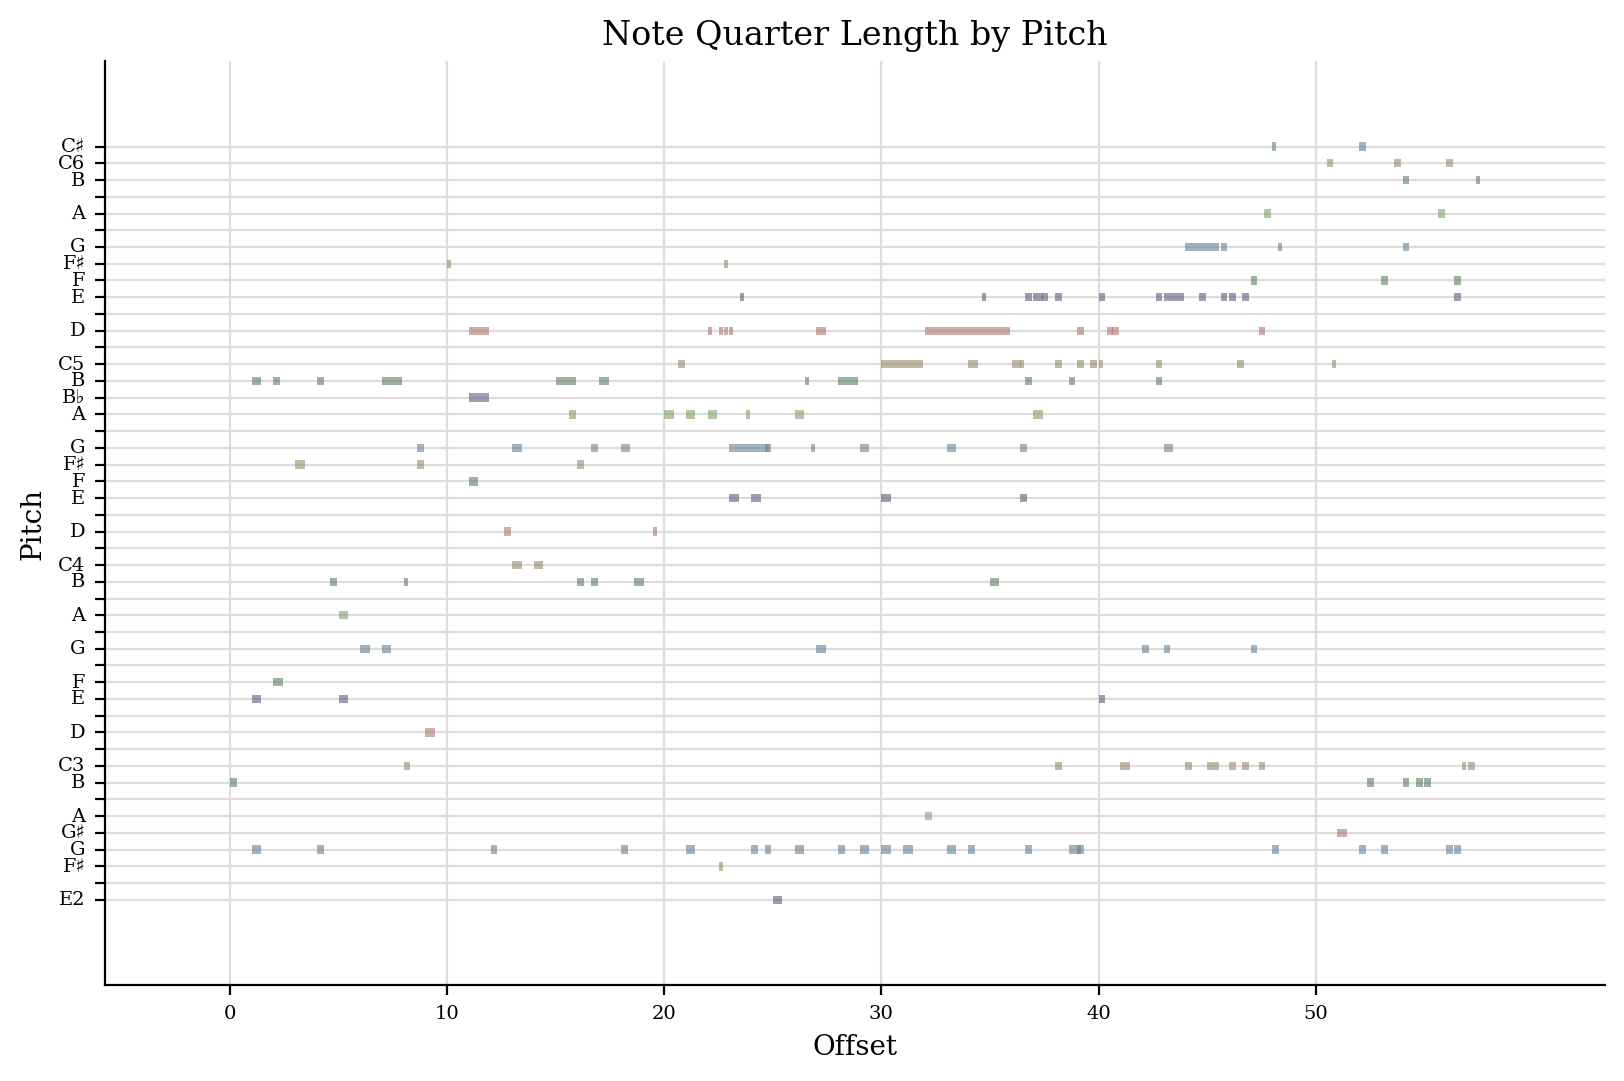

In [25]:
generated_stream = idx_to_stream_enc(np.array(generated_tokens[0, :, 0]), vocab)
generated_stream.plot()

In [26]:
generated_stream.show('midi')